In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
G=nx.Graph()

In [3]:
G.__dict__

{'_adj': {},
 '_node': {},
 'adjlist_inner_dict_factory': dict,
 'adjlist_outer_dict_factory': dict,
 'edge_attr_dict_factory': dict,
 'graph': {},
 'graph_attr_dict_factory': dict,
 'node_attr_dict_factory': dict,
 'node_dict_factory': dict}

In [2]:
from Types import *
from Functions import *
from main import *


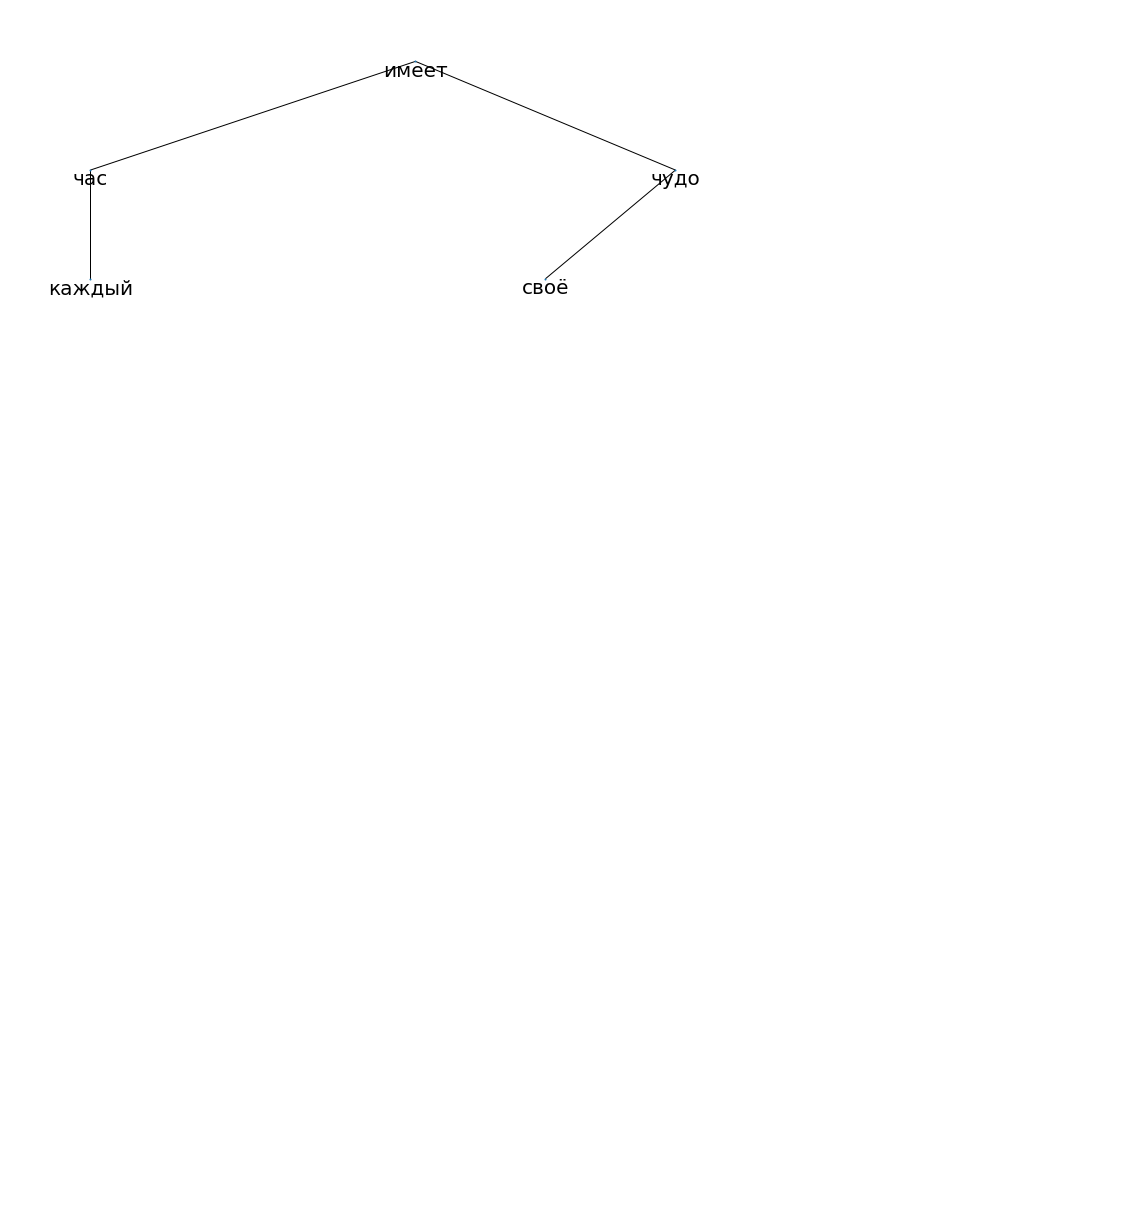

In [3]:
parse(db, "Каждый час имеет своё чудо.")

In [2]:
import copy
from Types import *
from Functions import *
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
import postgresql
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

class GPattern:
    def __init__(self, l = -1, textWord = "", depWordConstr = None, p = "", m = 0.0):
        self.level = l
        self.dependentWord = textWord
        if (depWordConstr == None):
            self.dependentWordConstraints = []
        else:
            self.dependentWordConstraints = copy.deepcopy(depWordConstr)
        self.mark = m
        self.prep = p
        self.info = ""# ????


class GPatternList:
    def __init__(self):
        self.firstLevel = []
        self.secondLevel = []
        self.thirdLevel = []
def extractFirstLevel(word, curMorf, db):
    s1 = "SELECT number_morf FROM morf_characters_of_word WHERE " + \
        "s_cl = \'" + str(curMorf.s_cl).split('.')[1] + "\' AND " + \
        "animate = \'" + str(curMorf.animate).split('.')[1] + "\' AND " + \
        "gender = \'" + str(curMorf.gender).split('.')[1] + "\' AND " + \
        "number = \'" + str(curMorf.number).split('.')[1] + "\' AND " + \
        "case1 = \'" + str(curMorf.case1).split('.')[1] + "\' AND " + \
        "reflection = \'" + str(curMorf.reflection).split('.')[1] + "\' AND " + \
        "perfective = \'" + str(curMorf.perfective).split('.')[1] + "\' AND " + \
        "transitive = \'" + str(curMorf.transitive).split('.')[1] + "\' AND " + \
        "person = \'" + str(curMorf.person).split('.')[1] + "\' AND " + \
        "tense = \'" + str(curMorf.tense).split('.')[1] + "\' AND " + \
        "voice = \'" + str(curMorf.voice).split('.')[1] + "\' AND " + \
        "degree = \'" + str(curMorf.degree).split('.')[1] + "\' AND " + \
        "static = \'" + str(curMorf.static) + "\'"
    # s1 - получение номера морфа(один морф в идеале)
    s2 = "WITH morf AS (" + s1 + "), " + \
        "num_models AS (SELECT model_1_level.number_model FROM model_1_level, morf WHERE ref_to_main_morf = morf.number_morf), " + \
        "mod AS (SELECT model_1_level.* FROM model_1_level, num_models WHERE model_1_level.number_model = num_models.number_model), " + \
        "prop AS (SELECT number_model, morf_characters_of_word.* FROM mod, morf_characters_of_word WHERE mod.ref_to_dep_morf = morf_characters_of_word.number_morf), " + \
        "imp AS (SELECT number_model, important_features.* FROM mod, important_features WHERE mod.imp_feat_dep = important_features.number_imp_feat), " + \
        "pr AS (SELECT prep_text, number_model FROM prep, mod WHERE mod.prep = prep.number_prep) " + \
        "SELECT mod.mark, pr.prep_text, imp.*, prop.* FROM imp, prop, pr, mod WHERE imp.number_model = prop.number_model AND imp.number_model = mod.number_model AND pr.number_model = mod.number_model;"
    #print(s2)
    res = db.query(s2)
    firLev = []
    shiftImpFeat = 4
    shiftProp = 19
    #print(res)
    for curConstr in res:
        curPatt = GPattern(1)
        oneModelConstr = []
        for j in range(0, 13): #13 - количество свойств в Morf
            if (curConstr[shiftImpFeat + j] == True):
                oneModelConstr.append(curConstr[shiftProp + j])
        curPatt.dependentWordConstraints += oneModelConstr
        curPatt.mark = curConstr[0]
        curPatt.prep = curConstr[1]
        firLev.append(curPatt)
    #print(firLev)
    return firLev

def extractSecondLevel(word, curMorf, db):
    s0 = "SELECT number_morf FROM morf_characters_of_word WHERE " + \
        "s_cl = \'" + str(curMorf.s_cl).split('.')[1] + "\' AND " + \
        "animate = \'" + str(curMorf.animate).split('.')[1] + "\' AND " + \
        "gender = \'" + str(curMorf.gender).split('.')[1] + "\' AND " + \
        "number = \'" + str(curMorf.number).split('.')[1] + "\' AND " + \
        "case1 = \'" + str(curMorf.case1).split('.')[1] + "\' AND " + \
        "reflection = \'" + str(curMorf.reflection).split('.')[1] + "\' AND " + \
        "perfective = \'" + str(curMorf.perfective).split('.')[1] + "\' AND " + \
        "transitive = \'" + str(curMorf.transitive).split('.')[1] + "\' AND " + \
        "person = \'" + str(curMorf.person).split('.')[1] + "\' AND " + \
        "tense = \'" + str(curMorf.tense).split('.')[1] + "\' AND " + \
        "voice = \'" + str(curMorf.voice).split('.')[1] + "\' AND " + \
        "degree = \'" + str(curMorf.degree).split('.')[1] + "\' AND " + \
        "static = \'" + str(curMorf.static) + "\'"
    #получение морфа
    s1 = "WITH number_morf AS (" + s0 +"), number_word AS (SELECT number_word FROM word, number_morf  WHERE word.word_text = \'" + word + "\' AND word.ref_to_morf = number_morf.number_morf),"
    # s1 - получение номера главного слова(одно слово в идеале)
    s2 = s1 + \
    "mod AS (SELECT * FROM model_2_level, number_word WHERE model_2_level.ref_to_main_word = number_word.number_word), prop AS (SELECT number_model, morf_characters_of_word.* FROM mod, morf_characters_of_word WHERE mod.ref_to_dep_morf = morf_characters_of_word.number_morf), imp AS (SELECT number_model, important_features.* FROM mod, important_features WHERE mod.imp_feat_dep = important_features.number_imp_feat), pr AS (SELECT prep_text, number_model FROM prep, mod WHERE mod.prep = prep.number_prep) SELECT mod.mark, pr.prep_text, imp.*, prop.* FROM imp, prop, pr, mod WHERE imp.number_model = prop.number_model AND imp.number_model = mod.number_model AND pr.number_model = mod.number_model;"

    #print(s2)
    res = db.query(s2)
    secLev = []
    shiftImpFeat = 4
    shiftProp = 19
    #print(res)
    for curConstr in res:
        curPatt = GPattern(2)
        oneModelConstr = []
        for j in range(0, 13): #13 - количество свойств в Morf
            if (curConstr[shiftImpFeat + j] == True):
                oneModelConstr.append(curConstr[shiftProp + j])
        curPatt.dependentWordConstraints += oneModelConstr
        curPatt.mark = curConstr[0]
        curPatt.prep = curConstr[1]
        secLev.append(curPatt)
    #print(secLev)
    return secLev

def extractThirdLevel(word, curMorf, db):
    s0 = "SELECT number_morf FROM morf_characters_of_word WHERE " + \
        "s_cl = \'" + str(curMorf.s_cl).split('.')[1] + "\' AND " + \
        "animate = \'" + str(curMorf.animate).split('.')[1] + "\' AND " + \
        "gender = \'" + str(curMorf.gender).split('.')[1] + "\' AND " + \
        "number = \'" + str(curMorf.number).split('.')[1] + "\' AND " + \
        "case1 = \'" + str(curMorf.case1).split('.')[1] + "\' AND " + \
        "reflection = \'" + str(curMorf.reflection).split('.')[1] + "\' AND " + \
        "perfective = \'" + str(curMorf.perfective).split('.')[1] + "\' AND " + \
        "transitive = \'" + str(curMorf.transitive).split('.')[1] + "\' AND " + \
        "person = \'" + str(curMorf.person).split('.')[1] + "\' AND " + \
        "tense = \'" + str(curMorf.tense).split('.')[1] + "\' AND " + \
        "voice = \'" + str(curMorf.voice).split('.')[1] + "\' AND " + \
        "degree = \'" + str(curMorf.degree).split('.')[1] + "\' AND " + \
        "static = \'" + str(curMorf.static) + "\'"
    #получение морфа
    s1 = "WITH number_morf AS (" + s0 +"), number_word AS (SELECT number_word FROM word, number_morf  WHERE word.word_text = \'" + word + "\' AND word.ref_to_morf = number_morf.number_morf),"
    # s1 - получение номера главного слова(одно слово в идеале)
    s2 = s1 + \
    "mod AS (SELECT * FROM model_3_level, number_word WHERE model_3_level.ref_to_main_word = number_word.number_word), w AS (SELECT number_model, word.* FROM mod, word WHERE mod.ref_to_dep_word = word.number_word), imp AS (SELECT number_model, important_features.* FROM mod, important_features WHERE mod.imp_feat_dep = important_features.number_imp_feat), pr AS (SELECT prep_text, number_model FROM prep, mod WHERE mod.prep = prep.number_prep), prop AS (SELECT * FROM morf_characters_of_word, w WHERE morf_characters_of_word.number_morf = w.ref_to_morf) SELECT mod.mark, pr.prep_text, imp.*, prop.* FROM imp, w, pr, mod, prop WHERE imp.number_model = w.number_model AND imp.number_model = mod.number_model AND pr.number_model = mod.number_model AND prop.number_model = mod.number_model;"

    #print(s2)
    res = db.query(s2)
    thLev = []
    shiftImpFeat = 4
    shiftProp = 18
    #print(res)
    for curConstr in res:
        curPatt = GPattern(3)
        oneModelConstr = []
        for j in range(0, 13): #13 - количество свойств в Morf
            if (curConstr[shiftImpFeat + j] == True):
                oneModelConstr.append(curConstr[shiftProp + j])
        curPatt.dependentWordConstraints += oneModelConstr
        curPatt.mark = curConstr[0]
        curPatt.prep = curConstr[1]
        curPatt.dependentWord = curConstr[34]
        #print(curPatt.dependentWord)
        thLev.append(curPatt)
    #print(thLev)
    return thLev

class Word:
    def morfParse(self):
        p = morph.parse(self.word)
        for curParse in p:
            m = parseToMorf(self.word, curParse)
            self.morf.append(m)
            if (m.s_cl == Es_cl.preposition):
                self.canPrep = True

    def getGPatterns(self, db):
        for curMorf in self.morf:
            curPatt = GPatternList()
            curFirst = extractFirstLevel(self.word, curMorf, db)
            curSec = extractSecondLevel(self.word, curMorf, db)
            curThird = extractThirdLevel(self.word, curMorf, db)
            curPatt.firstLevel += curFirst
            curPatt.secondLevel += curSec
            curPatt.thirdLevel += curThird
            self.gPatterns.append(curPatt)

    def __init__(self, name = "", number = -1):
        self.word = name  # у Одинцева Word

        self.morf = []  # список объектов типа Morf

        # список морфологических характеристик для всех вариантов морф. анализа
        self.gPatterns = []  # список из GPatternList, i элемент - для i morf
        # с помощью морф.анализатора заполняем morf, с помощью базы - GPatterns
        self.canPrep = False # может ли слово быть использовано, как предлог
        self.numberInSentence = number

class Gp:
    def __init__(self):
        self.model = GPattern()
        self.depWord = Word()
        self.mark = 0
        self.level = 0

class ParsePointWord:
    def __init__(self):
        self.word = Word()
        self.parsed = False
        self.usedMorfAnswer = Morf()
        self.isUsedPrep = EUsedPrep.noPrep
        self.usedGp = []#типа Gp

class ParsePoint:
    directForIsApplicable = 1
    def __init__(self):
        self.parsePointWordList = []
        self.childParsePoint = []
    def getMark(self):
        summ = 0
        for curPointWord in self.parsePointWordList:
            if (curPointWord.parsed):
                summ += 0.01 # чтобы учитывать количество разобранных(важно, если одинаковые оценки, особенно 0)
                for curGp in curPointWord.usedGp:
                    summ += curGp.mark
        return summ

    def index(self, word1): # ищет в списке слов в данной точке разбора индекс данного слова(класса Word), вспомогательная функция
        for i in range(len(self.parsePointWordList)):
            if self.parsePointWordList[i].word == word1:
                return i
        return None
    
    def checkInderectDependency (self, numberMain, numberDep):
        depWord = self.parsePointWordList[numberDep]
        mainWord = self.parsePointWordList[numberMain]
        return True # ПЕРЕПИСАТЬ!!!!

    def checkIsWordInDependentGroup(self, numberMain, numberDep):
        return True # ПЕРЕПИСАТЬ!!!!!

    def checkMorf(self, morf, constraints):
        en = 0
        res = True
        for constr in range(len(constraints)):
            while (not (constraints[constr] in Enums[en]._member_names_)):
                en += 1
            nameEnum = Enums[en].__name__[1:].replace("case", "case1")
            if (str(morf.__dict__[nameEnum]) != Enums[en].__name__ + "." + constraints[constr]):
                res = False
                break
        return res

    def checkWord(self, depWord, gPattern): # на вход - потенциальное зависимое слово(или потенциальный предлог), модель управления
#  в какой морф.форме может быть зав.словом, None - не может быть
        constr = gPattern.dependentWordConstraints
        ans = 0
        if (gPattern.level == 3 and gPattern.dependentWord != depWord.word): # у 3 уровня не совпало слово
            return None
        for morf in depWord.morf:
            if (self.checkMorf(morf, constr)):
                return morf
        return None


    def rightMove(self, mainPPWord, gPatternToApply):
        numberUsedPrep = -1  # -1 - такого нет,  проверяем, что данный предлог встретился перед! зависимым словом Предполагаем, что данный предлог должен быть сама близким к зависимому из возможных
        # Шел с человеком с зонтом(человек с зонтом, т.к. иначе - непроективная конструкция) Важно, чтобы к зонту относилось второе с

        for numberDep in range(mainPPWord + 1, len(self.parsePointWordList),1):
            if (self.parsePointWordList[numberDep].parsed and self.parsePointWordList[numberDep].isUsedPrep == EUsedPrep.noPrep):
                if (self.checkInderectDependency(mainPPWord, numberDep) == False):
                    break
            else:
                depWord = self.parsePointWordList[numberDep].word
                morfForm = self.checkWord(depWord, gPatternToApply)
                if (morfForm != None and numberUsedPrep != -1 ):  # если уже был предлог, и данное i-слово удовлетворяет требованиям зависимости модели
                    return (True, numberUsedPrep, numberDep, morfForm)
                if (morfForm != None and gPatternToApply.prep == "None"):
                    return (True, None, numberDep, morfForm)
                if (depWord.canPrep and depWord.word == gPatternToApply.prep):
                    numberUsedPrep = numberDep #рассматриваемое слово может быть использовано, как предлог
        return (False, None, None, None)

    def leftMove(self, mainPPWord, gPatternToApply):
        # Шел с человеком с зонтом(человек с зонтом, т.к. иначе - непроективная конструкция) Важно, чтобы к зонту относилось второе с
# здесь сложнее, для каждого потенциального зависимого слова(которое уже подтвердили, что модель подходит), ищем, есть ли предлог слева..... - это тааак долго
        numbersPreps = [] # массив,в котором хранятся номера потенциальных предлогов(который нужен в модели управления )
        if (gPatternToApply.prep != "None"):
            for numberWord in range(0, mainPPWord):
                curWord = self.parsePointWordList[numberWord].word
                if (curWord.word == gPatternToApply.prep and curWord.canPrep):
                    numbersPreps.append(numberWord)
        for numberDep in range(mainPPWord - 1, -1 , -1):
            if (self.parsePointWordList[numberDep].parsed and self.parsePointWordList[numberDep].isUsedPrep == EUsedPrep.noPrep):
                if (self.checkInderectDependency(mainPPWord, numberDep) == False):
                    break
            else:
                depWord = self.parsePointWordList[numberDep].word
                morfForm = self.checkWord(depWord, gPatternToApply) # здесь нас не интересует maybePrep, т.к. предлог ищем слева
                if (morfForm != None):  # данное i-слово удовлетворяет требованиям зависимости модели
                    if (gPatternToApply.prep == "None"):
                        return (True, None, numberDep, morfForm)
                    if (numbersPreps[0] < numberDep): # есть предлоги(нужные) слева от потенц.зависимого
                        leftPrep = -1 # ищем самый правый из предлогов, которые слева от потенц.зависимого
                        for num in numbersPreps:
                            if (num < numberDep):
                                leftPrep = num
                            else:
                                break # Так как номера предлогов отсортированы по возрастанию
                        return (True, leftPrep, numberDep, morfForm)
        return (False, None, None, None)

    def isApplicable (self, mainPPWord, gPatternToApply): # где проверка предлогов???????
    #mainPPWord - номер главного!!!
        if (ParsePoint.directForIsApplicable > 0):
            (find, numberUsedPrep, numberDep, morfForm) = self.rightMove(mainPPWord, gPatternToApply)
            ParsePoint.directForIsApplicable = -ParsePoint.directForIsApplicable
            if (find):
                return (True, numberUsedPrep, numberDep, morfForm)
            return self.leftMove(mainPPWord, gPatternToApply)
        else:
            (find, numberUsedPrep, numberDep, morfForm) = self.leftMove(mainPPWord, gPatternToApply)
            ParsePoint.directForIsApplicable = -ParsePoint.directForIsApplicable
            if (find):
                return (True, numberUsedPrep, numberDep, morfForm)
            return self.rightMove(mainPPWord, gPatternToApply)



    def apply (self, mainPPWord, dependingPPWord, prepNumber, usedMorfAnswer, gPatternToApply):
        newParsePoint = copy.deepcopy(self)
        if (prepNumber != None):
            newParsePoint.parsePointWordList[prepNumber].parsed = True
            newParsePoint.parsePointWordList[prepNumber].isUsedPrep = EUsedPrep.usedPrep
        newParsePoint.parsePointWordList[dependingPPWord].parsed = True
        newParsePoint.parsePointWordList[dependingPPWord].usedMorfAnswer = usedMorfAnswer
        newGp = Gp()
        newGp.mark = gPatternToApply.mark
        newGp.level = gPatternToApply.level
        newGp.model = copy.deepcopy(gPatternToApply)
        newGp.depWord = self.parsePointWordList[dependingPPWord].word
        newParsePoint.parsePointWordList[mainPPWord].usedGp.append(newGp)
        return newParsePoint

    def getNextParsePoint(self): #(newPoint, flagFirstUse, firstWords)
        countParsed = 0
        parsed = []
        for i in range(len(self.parsePointWordList)):
            curPointWord = self.parsePointWordList[i]
            countParsed += curPointWord.parsed
            if (curPointWord.parsed == True):
                parsed.append(i)
        if (countParsed == 0):
            for i in range(len(self.parsePointWordList)):
                curPointWord = self.parsePointWordList[i]
                for curMorf in curPointWord.word.morf:
                    if curMorf.s_cl == Es_cl.verb:
                        newParsePoint = copy.deepcopy(self)
                        newParsePoint.parsePointWordList[i].parsed = True
                        newParsePoint.parsePointWordList[i].usedMorfAnswer = copy.deepcopy(curMorf)
                        self.childParsePoint.append(newParsePoint)
                        return (newParsePoint, True, [i]) # найдено первое для разбора слово
            #в предложении нет глагола
            for i in range(len(self.parsePointWordList)):
                curPointWord = self.parsePointWordList[i]
                for curMorf in curPointWord.word.morf:
                    if curMorf.s_cl == Es_cl.noun and curMorf.case1 == Ecase.nominative:
                        newParsePoint = copy.deepcopy(self)
                        newParsePoint.parsePointWordList[i].parsed = True
                        newParsePoint.parsePointWordList[i].usedMorfAnswer = copy.deepcopy(curMorf)
                        self.childParsePoint.append(newParsePoint)
                        return (newParsePoint, True, [i]) # найдено первое для разбора слово
        else:
            bestMainWord = Word()
            bestDepWord = Word()
            usedDepMorf = Morf()
            bestPrep = Word()
            bestModel = Gp()
            bestModelMark = 0
            for i in parsed:
                curParsedPoint = self.parsePointWordList[i]
                curWord = curParsedPoint.word
                chooseVarMorf = curParsedPoint.usedMorfAnswer
                models = None
                for j in range(len(curWord.morf)):
                    if (curWord.morf[j] == chooseVarMorf):
                        models = curWord.gPatterns[j]
                        break
                if (models != None):
                    for curModel in (models.thirdLevel + models.secondLevel + models.firstLevel):
                        (canApply, prep, depWord, morfDepWord) = self.isApplicable(i, curModel)
                        if (canApply and curModel.mark > bestModelMark): #!!!!!
                            bestPrep = prep
                            bestModelMark = curModel.mark
                            bestModel = copy.deepcopy(curModel)
                            bestMainWord = i
                            bestDepWord = depWord
                            usedDepMorf = morfDepWord
            if (bestModelMark != 0):
                newParsePoint = self.apply(bestMainWord, bestDepWord, bestPrep, usedDepMorf, bestModel)
                self.childParsePoint.append(newParsePoint)
                return (newParsePoint, False, None)
            print("No model")
            return (None, False, None)
        
        
    def addEdge(depth, newParsePointWordList, G1, shiftX, nameMainWord):
#добавляет в граф новую зависимую вершину и новую связь!
# beginIndex - строка, префикс названия 
# depth - глубина
#sList - исходное предложение - список слов
# shiftX - смещение по х всего блока точек,зависимых от данного
        for i in range(len(newParsePointWordList)):
            newParsePointWord = newParsePointWordList[i]
            newPointName = newParsePointWord.depWord.word
            G1.add_node(newPointName, pos = [shiftX + i * 9, 20 - 2 * depth])
            G1.add_edge(nameMainWord, newPointName)
            depWordText = newParsePointWord.depWord
            depWord1 = newParsePointWord.depWord
            depWordInd = depWord1.numberInSentence
            if (len(res.parsePointWordList[depWordInd].usedGp) != 0):
                addEdge(depth + 1, res.parsePointWordList[depWordInd].usedGp, G1, i * 7, newPointName)
    def visualizate(self, firstIndices):
        G1=nx.Graph()
        i = 0.5
        #for curWordParse in res.parsePointWordList:
        #    G1.add_node(curWordParse.word.word, pos = [i, 1])
        #    i += 4
        #for curPoint in parse1.usedGp:
        begin = firstIndices[0]
        parse1 = res.parsePointWordList[begin].usedGp
        max_x = 15
        max_y = 5.0
        # установить их потом!!!
        G1.add_node(textMainWord, pos = [5, 20])
        addEdge(1, parse1, G1, 0, textMainWord)
        pos=nx.get_node_attributes(G1,'pos')

        fig = plt.figure(figsize=(20,22))
        plt.scatter(max_x + 0.1, max_y + 0.1, s = 1, c = 'white')
        plt.scatter(-0.5, 0.0, s = 1, c = 'white')
        plt.scatter(max_x + 0.1, 0.0, s = 1, c = 'white')
        #pos=graphviz_layout(G1, prog='dot')
        nx.draw(G1, pos, with_labels = True, node_size=1, horizontalalignment='center', verticalalignment='top', font_size = 20)
class Sentence:
    def __init__(self):
        self.inputStr = ""
        self.wordList = []
        self.rootPP = ParsePoint()  # ????????
        self.firstUse = True
        self.firstParseWordsIndices = [] # слова, первые для разбора, в простых предложениях

    def setString(self, inputStr1):
        self.inputStr = inputStr1
        # слово в предложении - все, отделенное пробелом, точкой, ? ! ...(смотрим только на первую .)
        #: ; " ' началом предложения, запятой, (   ) тире вообще не учитываем(оно отделено пробелами),
        # дефис только в словах очень-очень и тп,
        punctuation = [' ', '.', '?', '!', ':', ';', '\'', '\"', ',', '(', ')']
        curWord = ""
        numberWord = 0
        for i in self.inputStr:
            if (i in punctuation):
                if (len(curWord) != 0):
                    self.wordList.append(Word(curWord.lower(), numberWord))
                    numberWord += 1
                    curWord = ""
            elif (i != '-' or (len(curWord) != 0)):  # - и непустое слово -  это дефис
                curWord = curWord + i
        if (len(curWord) != 0):
            self.wordList.append(Word(curWord.lower()), numberWord)


    def morfParse(self):
        for curWord in self.wordList:
            curWord.morfParse()

    def getGPatterns(self, db):
        for curWord in self.wordList:
            curWord.getGPatterns(db)

    def getRootParsePoint(self):
        self.rootPP = ParsePoint()
        for word in self.wordList:
            curParsePointWord = ParsePointWord()
            curParsePointWord.parsed = False
            curParsePointWord.word = word
            self.rootPP.parsePointWordList.append(curParsePointWord)
    def getBestParsePoint(self):
        bestPoint = self.rootPP
        bestPointMark = self.rootPP.getMark()
        for curChild in self.rootPP.childParsePoint:
            s1 = Sentence()
            s1.rootPP = curChild
            curBest = s1.getBestParsePoint()
            curMark = curBest.getMark()
            if (curMark > bestPointMark):
                bestPointMark = curMark
                bestPoint = curBest

        return bestPoint
    
# проверка связности - считаем, сколько слов в связном дереве, если = кол-ву слов, то все ок
# на вход - res(т.е. bestParsePoint)
    def countDependent(curParsePoint, firstWordIndex):
        newParsePointWord = curParsePoint.parsePointWordList[firstWordIndex]
        count = 1
        for curModel in newParsePointWord.usedGp:
            depWord1 = curModel.depWord
            print(depWord1.word)
            count +=  countDependent(curParsePoint, depWord1.numberInSentence)
        return count
    def checkConnectivity(self, curParsePoint): # параметр - предложение
        return len(self.wordList) == countDependent(curParsePoint, self.firstParseWordsIndices[0])
    
    def sintParse(self, needTrace = False):
        if (needTrace):
            tracePoints = []
        if (self.firstUse == True):
            self.firstUse = False
            self.getRootParsePoint()
        bestParsePoint = self.getBestParsePoint()
        if (bestParsePoint == None):
            print("Больше вариантов разбора нет")
            return None
        allWordsParsed = True
        
        for curPointWord in bestParsePoint.parsePointWordList:
            if (curPointWord.parsed == False):
                allWordsParsed = False
                break
        while (allWordsParsed == False):
            #for ti in range(len(bestParsePoint.parsePointWordList)):
            #    print(bestParsePoint.parsePointWordList[ti].parsed)
            #print("----------------")
            (newPoint, flagFirstUse, firstWords) = bestParsePoint.getNextParsePoint()
            if (newPoint == None):
                print("Не разобрано!")
                if (needTrace):
                    return (bestParsePoint, tracePoints)
                return (bestParsePoint)
            if (needTrace):
                tracePoints.append(newPoint)
            if (flagFirstUse):
                self.firstParseWordsIndices = firstWords
            s1 = Sentence()
            s1.rootPP = bestParsePoint# а надо ли copy ???
            bestParsePoint = s1.getBestParsePoint()
            allWordsParsed = True
            for curPointWord in bestParsePoint.parsePointWordList:
                if (curPointWord.parsed == False):
                    allWordsParsed = False
                    break
        if (needTrace):
            return (bestParsePoint, tracePoints)
        return (bestParsePoint)

def parse(db, str1, needTrace = False):
        s = Sentence()
        s.setString(str1)
        s.morfParse()
        s.getGPatterns(db)
        res = s.sintParse(needTrace)
        if (needTrace):
            res[0].visualizate(s.firstParseWordsIndices)
        else:
            res.visualizate(s.firstParseWordsIndices)
        return res


In [4]:
parse(db, "Каждый час имеет своё чудо.")

NameError: name 'res' is not defined

In [89]:
db = postgresql.open('pq://derin:qwerty@localhost:5432/models')
s = Sentence()
s.setString("Каждый час имеет своё чудо.")# пред тем, кто его носит.")
s.morfParse()
s.getGPatterns(db)
res = s.sintParse()
res.vi

No model
Не разобрано!
час
каждый
каждый
час
чудо
своё
своё
чудо
False


In [48]:
s.wordList[2].__dict__

{'canPrep': False,
 'gPatterns': [<__main__.GPatternList at 0x7fd0785d8470>],
 'morf': [<Types.Morf at 0x7fd078664278>],
 'numberInSentence': 2,
 'word': 'имеет'}

In [49]:
firstWordIndex = 2

In [50]:
res.parsePointWordList[firstWordIndex]

In [80]:
s.__dict__

{'firstParseWordsIndices': [2],
 'firstUse': False,
 'inputStr': 'Каждый час имеет своё чудо.',
 'rootPP': <__main__.ParsePoint at 0x7fd0786646a0>,
 'wordList': [<__main__.Word at 0x7fd078664518>,
  <__main__.Word at 0x7fd078664320>]}

In [68]:
count = 0

In [84]:
# проверка связности - считаем, сколько слов в связном дереве, если = кол-ву слов, то все ок
# на вход - res(т.е. bestParsePoint)
def countDependent(curParsePoint, firstWordIndex):
    newParsePointWord = curParsePoint.parsePointWordList[firstWordIndex]
    count = 1
    for curModel in newParsePointWord.usedGp:
        depWord1 = curModel.depWord
        print(depWord1.word)
        count +=  countDependent(curParsePoint, depWord1.numberInSentence)
    return count
def checkConnectivity(self, curParsePoint): # параметр - предложение
    return len(self.wordList) == countDependent(curParsePoint, self.firstParseWordsIndices[0])

In [86]:
q = checkConnectivity(s, res)

час
каждый
чудо
своё


In [87]:
q

True

In [66]:
newParsePointWord.usedGp[0].depWord.__dict__

{'canPrep': False,
 'gPatterns': [<__main__.GPatternList at 0x7fd0785c9c88>,
 'morf': [<Types.Morf at 0x7fd0785c9ef0>, <Types.Morf at 0x7fd0785c52e8>],
 'numberInSentence': 1,
 'word': 'час'}

In [18]:
res.parsePointWordList

In [7]:
s.__dict__

{'firstParseWordsIndices': [2],
 'firstUse': False,
 'inputStr': 'Каждый час имеет своё чудо.',
 'rootPP': <__main__.ParsePoint at 0x7f889bc4cf98>,
 'wordList': [<__main__.Word at 0x7f889bc4c9b0>,
  <__main__.Word at 0x7f889bc4ca90>]}

In [15]:
a = s.wordList[0] 

In [29]:
s.wordList

In [97]:
def addEdge(depth, newParsePointWordList, G1, shiftX, nameMainWord):

# beginIndex - строка, префикс названия 
# depth - глубина
#sList - исходное предложение - список слов
# shiftX - смещение по х всего блока точек,зависимых от данного
    for i in range(len(newParsePointWordList)):
        newParsePointWord = newParsePointWordList[i]
        newPointName = newParsePointWord.depWord.word
        G1.add_node(newPointName, pos = [shiftX + i * 9, 20 - 2 * depth])
        G1.add_edge(nameMainWord, newPointName)
        depWordText = newParsePointWord.depWord
        depWord1 = newParsePointWord.depWord
        depWordInd = depWord1.numberInSentence
        if (len(res.parsePointWordList[depWordInd].usedGp) != 0):
            addEdge(depth + 1, res.parsePointWordList[depWordInd].usedGp, G1, i * 7, newPointName)

In [92]:
begin = s.firstParseWordsIndices[0]

In [93]:
begin = s.firstParseWordsIndices[0]
parse1 = res.parsePointWordList[begin].usedGp
textMainWord = res.parsePointWordList[begin].word.word

In [34]:
parse1

[<__main__.Gp at 0x7fd0785c90f0>, <__main__.Gp at 0x7fd0785c9160>]

In [21]:
res.parsePointWordList[2].__dict__

{'isUsedPrep': <EUsedPrep.noPrep: 1>,
 'parsed': True,
 'usedGp': [<__main__.Gp at 0x7fd079652cf8>, <__main__.Gp at 0x7fd079652c18>],
 'usedMorfAnswer': <Types.Morf at 0x7fd0796524e0>,
 'word': <__main__.Word at 0x7fd079652668>}

In [94]:
textMainWord

'имеет'

In [23]:
Везде заменить s на self !!!

SyntaxError: invalid syntax (<ipython-input-23-9a7590d62b3d>, line 1)

In [95]:
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

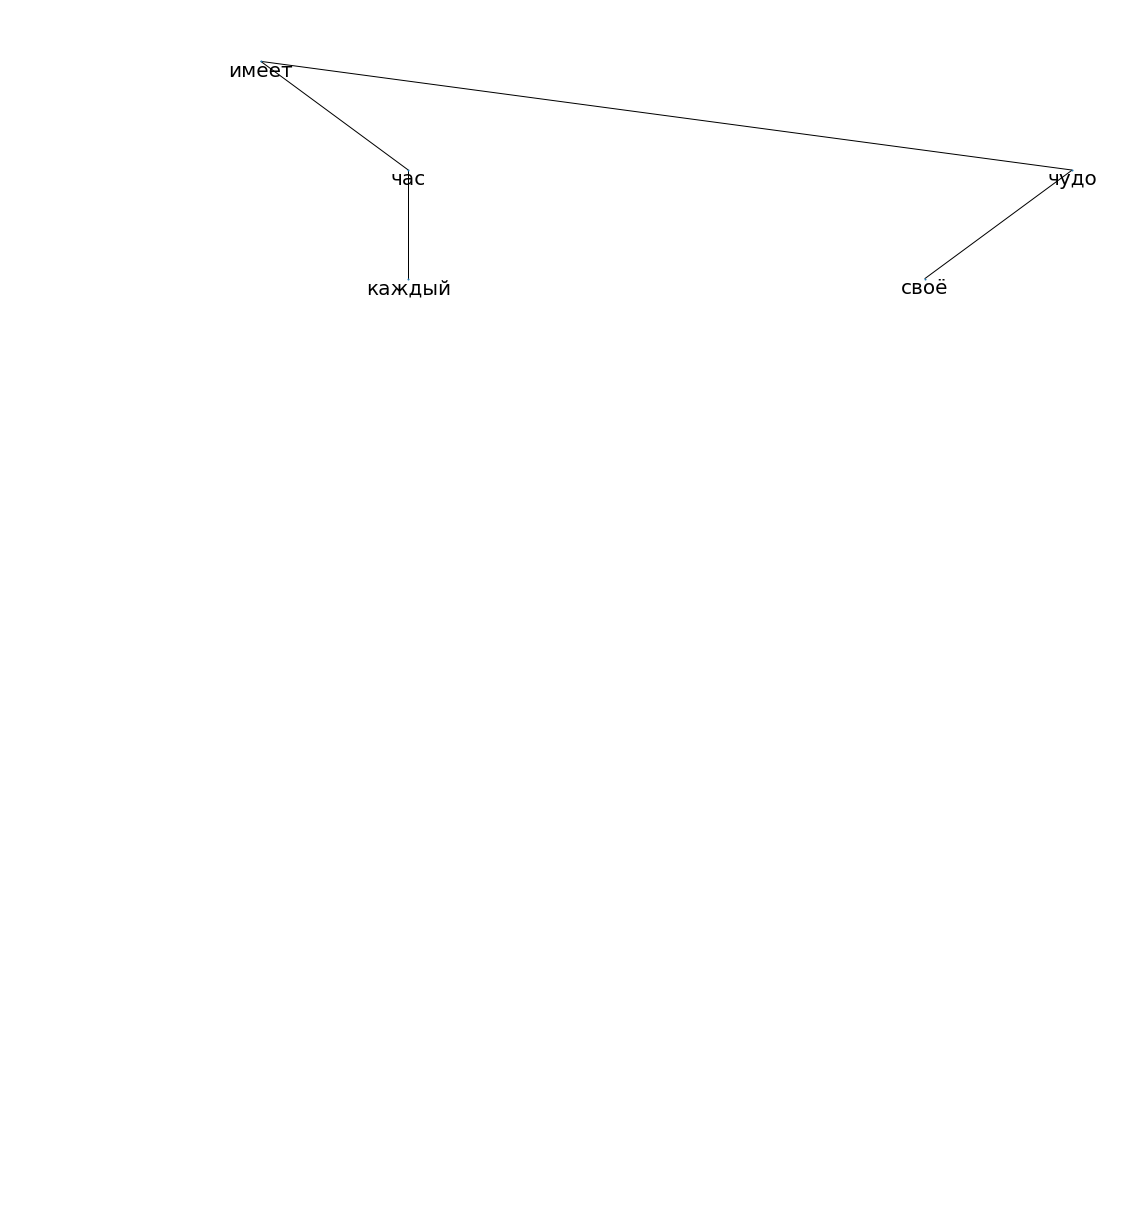

In [98]:
G1=nx.Graph()
i = 0.5
#for curWordParse in res.parsePointWordList:
#    G1.add_node(curWordParse.word.word, pos = [i, 1])
#    i += 4
#for curPoint in parse1.usedGp:
    
max_x = 15
max_y = 5.0
# установить их потом!!!
G1.add_node(textMainWord, pos = [5, 20])
sList = []
for curWord in s.wordList:
    sList.append(curWord.word)
addEdge(1, parse1, G1, 0, textMainWord)
pos=nx.get_node_attributes(G1,'pos')

fig = plt.figure(figsize=(20,22))
plt.scatter(max_x + 0.1, max_y + 0.1, s = 1, c = 'white')
plt.scatter(-0.5, 0.0, s = 1, c = 'white')
plt.scatter(max_x + 0.1, 0.0, s = 1, c = 'white')
#pos=graphviz_layout(G1, prog='dot')
nx.draw(G1, pos, with_labels = True, node_size=1, horizontalalignment='center', verticalalignment='top', font_size = 20)

In [78]:
set(G1.nodes)

{'имеет', 'каждый', 'своё', 'час', 'чудо'}

In [81]:
# проверка - что любое слово из предложения встречается в вершинах графа!
Но что делать, если слово встречается два раза ?
Word у них разный! 
Проблема только в графе 

SyntaxError: invalid syntax (<ipython-input-81-ecb198c41a98>, line 2)

In [70]:
G1.__dict__

{'_adj': {'имеет': {'час': {}, 'чудо': {}},
  'каждый': {'час': {}},
  'своё': {'чудо': {}},
  'час': {'имеет': {}, 'каждый': {}},
  'чудо': {'имеет': {}, 'своё': {}}},
 '_node': {'имеет': {'pos': [5, 20]},
  'каждый': {'pos': [0, 16]},
  'своё': {'pos': [7, 16]},
  'час': {'pos': [0, 18]},
  'чудо': {'pos': [9, 18]}},
 'adjlist_inner_dict_factory': dict,
 'adjlist_outer_dict_factory': dict,
 'edge_attr_dict_factory': dict,
 'graph': {},
 'graph_attr_dict_factory': dict,
 'node_attr_dict_factory': dict,
 'node_dict_factory': dict,
 'nodes': NodeView(('каждый', 'час', 'имеет', 'чудо', 'своё'))}

In [ ]:
#вычислить формулу зависимости координат точки
1. от уровня
2. от номера группы по Х
3. от номера в группе по Х

In [ ]:
# при выделении главных слов - сохранять их в массив первых для разбора слов
Тогда все сложные предложения будут разбираться, как набор простых
И сложные предложения - те, которые имеют более чем одну основу(массив первых слов - более 1 члена)
Сложные предложение отдельно выделить, на разбор все это особо влиять не будет!!!
отдельно поставить блок связывания ССП и СПП(кроме бессоюзных).
Нет необходимости хранить в базе модели управления тем, кем и тп связывающие части сложнх предложений

In [22]:
G1.__dict__

{'_adj': {'a1': {'a10': {}, 'a11': {}},
  'a10': {'a1': {}, 'a100': {}},
  'a100': {'a10': {}},
  'a11': {'a1': {}, 'a110': {}},
  'a110': {'a11': {}}},
 '_node': {'a1': {'pos': [5, 20]},
  'a10': {'pos': [0, 18]},
  'a100': {'pos': [0, 16]},
  'a11': {'pos': [3, 18]},
  'a110': {'pos': [7, 16]}},
 'adjlist_inner_dict_factory': dict,
 'adjlist_outer_dict_factory': dict,
 'edge_attr_dict_factory': dict,
 'graph': {},
 'graph_attr_dict_factory': dict,
 'node_attr_dict_factory': dict,
 'node_dict_factory': dict,
 'nodes': NodeView(('a110', 'a100', 'a10', 'a11', 'a1'))}

In [36]:
G1.__dict__

{'_adj': {'1': {'именем': {}, 'перед': {}, 'страх': {}},
  '2': {'страх': {}, 'усиливает': {}},
  '3': {'ужас': {}, 'усиливает': {}},
  'именем': {'1': {}},
  'перед': {'1': {}},
  'страх': {'1': {}, '2': {}},
  'ужас': {'3': {}},
  'усиливает': {'2': {}, '3': {}}},
 '_node': {'1': {'pos': [8, 5]},
  '2': {'pos': [11, 5]},
  '3': {'pos': [14, 5]},
  'именем': {'pos': [8.5, 1]},
  'перед': {'pos': [4.5, 1]},
  'страх': {'pos': [0.5, 1]},
  'ужас': {'pos': [16.5, 1]},
  'усиливает': {'pos': [12.5, 1]}},
 'adjlist_inner_dict_factory': dict,
 'adjlist_outer_dict_factory': dict,
 'edge_attr_dict_factory': dict,
 'graph': {},
 'graph_attr_dict_factory': dict,
 'node_attr_dict_factory': dict,
 'node_dict_factory': dict,
 'nodes': NodeView(('ужас', '3', '2', 'именем', 'перед', 'страх', 'усиливает', '1'))}

In [33]:
G1.pos

AttributeError: 'Graph' object has no attribute 'pos'

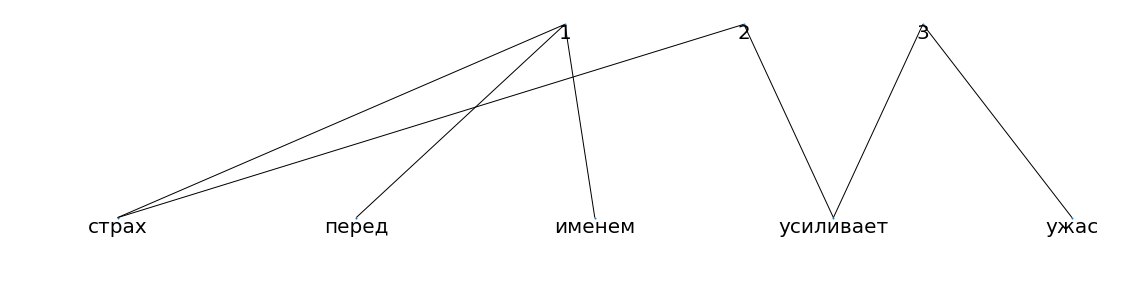

In [12]:
#старая версия
G1=nx.Graph()
i = 0.5
for curWordParse in res.parsePointWordList:
    G1.add_node(curWordParse.word.word, pos = [i, 1])
    i += 4
max_x = i
numberPoint = 1
for curWordParse in res.parsePointWordList:
    mainWord = curWordParse.word.word
    for curPatt in curWordParse.usedGp:
        point = str(numberPoint)
        G1.add_node(point, pos = [numberPoint * 3 + 5, 5])
        G1.add_edge(point, mainWord)
        G1.add_edge(point, curPatt.depWord.word)
        if (curPatt.model.prep != "None"):
            G1.add_edge(point, curPatt.model.prep)
        #print(mainWord, curPatt.depWord.word)
        #G1.add_edge("")
        #print(curPatt.depWord.word)
        numberPoint += 1
pos=nx.get_node_attributes(G1,'pos')
max_x = 15
max_y = 5.0
# установить их потом!!!

fig = plt.figure(figsize=(20,5))
plt.scatter(max_x + 0.1, max_y + 0.1, s = 1, c = 'white')
plt.scatter(-0.5, 0.0, s = 1, c = 'white')
plt.scatter(max_x + 0.1, 0.0, s = 1, c = 'white')
nx.draw(G1, pos, with_labels = True, node_size=1, horizontalalignment='center', verticalalignment='top', font_size = 20)

In [35]:
G1.__dict__

{'_adj': {'1': {'именем': {}, 'перед': {}, 'страх': {}},
  '2': {'страх': {}, 'усиливает': {}},
  '3': {'ужас': {}, 'усиливает': {}},
  'именем': {'1': {}},
  'перед': {'1': {}},
  'страх': {'1': {}, '2': {}},
  'ужас': {'3': {}},
  'усиливает': {'2': {}, '3': {}}},
 '_node': {'1': {'pos': [8, 5]},
  '2': {'pos': [11, 5]},
  '3': {'pos': [14, 5]},
  'именем': {'pos': [8.5, 1]},
  'перед': {'pos': [4.5, 1]},
  'страх': {'pos': [0.5, 1]},
  'ужас': {'pos': [16.5, 1]},
  'усиливает': {'pos': [12.5, 1]}},
 'adjlist_inner_dict_factory': dict,
 'adjlist_outer_dict_factory': dict,
 'edge_attr_dict_factory': dict,
 'graph': {},
 'graph_attr_dict_factory': dict,
 'node_attr_dict_factory': dict,
 'node_dict_factory': dict,
 'nodes': NodeView(('ужас', '3', '2', 'именем', 'перед', 'страх', 'усиливает', '1'))}

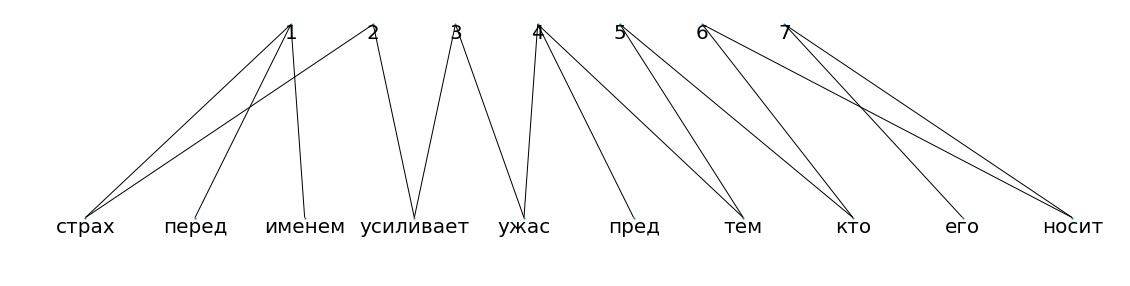

In [2]:
main("Страх перед именем усиливает ужас пред тем, кто его носит.")

In [56]:
db = postgresql.open('pq://derin:qwerty@localhost:5432/models')
s = Sentence()
s.setString("Вознесла возницу, ежиться с ежом.")
s.morfParse()
s.getGPatterns()
res = s.sintParse()

IndexError: list index out of range

In [38]:
res.__dict__

{'childParsePoint': [],
 'parsePointWordList': [<prob.ParsePointWord at 0x7f69c097c908>,
  <prob.ParsePointWord at 0x7f69c097feb8>]}

In [33]:
res.parsePointWordList[0].usedGp[0].model.prep

'с'

In [28]:
res.parsePointWordList[0].usedGp[0].__dict__

{'depWord': <prob.Word at 0x7f5d94743780>,
 'level': 3,
 'mark': 1.0,
 'model': <prob.GPattern at 0x7f5d947404e0>}

In [27]:
res.parsePointWordList[0].__dict__

{'isUsedPrep': <EUsedPrep.noPrep: 1>,
 'parsed': True,
 'usedGp': [<prob.Gp at 0x7f5d94743dd8>],
 'usedMorfAnswer': <Types.Morf at 0x7f5d94743908>,
 'word': <prob.Word at 0x7f5d947432e8>}

In [28]:
res.parsePointWordList[1].__dict__

{'isUsedPrep': <EUsedPrep.usedPrep: 2>,
 'parsed': True,
 'usedGp': [],
 'usedMorfAnswer': <Types.Morf at 0x7f69c25dde10>,
 'word': <prob.Word at 0x7f69c25ddd30>}

In [48]:
G1=nx.Graph()
i = 0.5
for curWordParse in res.parsePointWordList:
    G1.add_node(curWordParse.word.word, pos = [i, 1])
    i += 0.5
    
numberPoint = 1
for curWordParse in res.parsePointWordList:
    mainWord = curWordParse.word.word
    for curPatt in curWordParse.usedGp:
        point = str(numberPoint)
        G1.add_node(point, pos = [numberPoint / 2 + 0.5, 3])
        G1.add_edge(point, mainWord)
        G1.add_edge(point, curPatt.depWord.word)
        if (curPatt.model.prep != "None"):
            G1.add_edge(point, curPatt.model.prep)
        #print(mainWord, curPatt.depWord.word)
        #G1.add_edge("")
        #print(curPatt.depWord.word)
pos=nx.get_node_attributes(G1,'pos')
max_x = 1.5
max_y = 2.0
# установить их потом!!!

fig = plt.figure(figsize=(10,5))
plt.scatter(max_x + 0.1, max_y + 0.1, s = 1, c = 'white')
plt.scatter(-0.5, 0.0, s = 1, c = 'white')
plt.scatter(max_x + 0.1, 0.0, s = 1, c = 'white')
nx.draw(G1, pos, with_labels = True, node_size=1, horizontalalignment='center', verticalalignment='top')

In [ ]:
main()

In [49]:
G1.__dict__

{'_adj': {'1': {'вознесла': {}, 'возницу': {}},
  'вознесла': {'1': {}},
  'возницу': {'1': {}}},
 '_node': {'1': {'pos': [1.0, 3]},
  'вознесла': {'pos': [0.5, 1]},
  'возницу': {'pos': [1.0, 1]}},
 'adjlist_inner_dict_factory': dict,
 'adjlist_outer_dict_factory': dict,
 'edge_attr_dict_factory': dict,
 'graph': {},
 'graph_attr_dict_factory': dict,
 'node_attr_dict_factory': dict,
 'node_dict_factory': dict}

In [50]:
pos=nx.get_node_attributes(G1,'pos')

In [51]:
pos

{'1': [1.0, 3], 'вознесла': [0.5, 1], 'возницу': [1.0, 1]}

In [52]:
max_x = 1.5
max_y = 2.0
# установить их потом!!!

In [53]:
import matplotlib.pyplot as plt

In [54]:
fig = plt.figure(figsize=(10,5))

<Figure size 720x360 with 0 Axes>

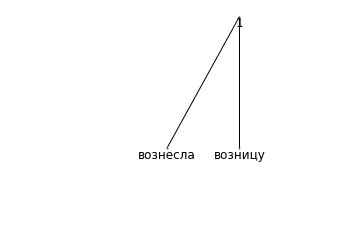

In [55]:
plt.scatter(max_x + 0.1, max_y + 0.1, s = 1, c = 'white')
plt.scatter(-0.5, 0.0, s = 1, c = 'white')
plt.scatter(max_x + 0.1, 0.0, s = 1, c = 'white')
nx.draw(G1, pos, with_labels = True, node_size=1, horizontalalignment='center', verticalalignment='top')

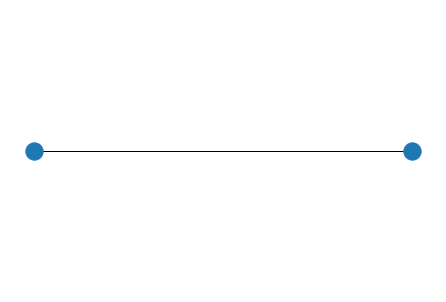

In [15]:
G=nx.Graph()

G.add_node(1,pos=(1,2))

G.add_node(2,pos=(2,2))

G.add_edge(1,2)

pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos)


In [79]:
G1.__dict__

{'_adj': {'ежом': {}, 'с': {}, 'ёжиться': {}},
 '_node': {'ежом': {'pos': [3, 5]},
  'с': {'pos': [2, 5]},
  'ёжиться': {'pos': [1, 5]}},
 'adjlist_inner_dict_factory': dict,
 'adjlist_outer_dict_factory': dict,
 'edge_attr_dict_factory': dict,
 'graph': {},
 'graph_attr_dict_factory': dict,
 'node_attr_dict_factory': dict,
 'node_dict_factory': dict,
 'nodes': NodeView(('ежом', 'ёжиться', 'с'))}

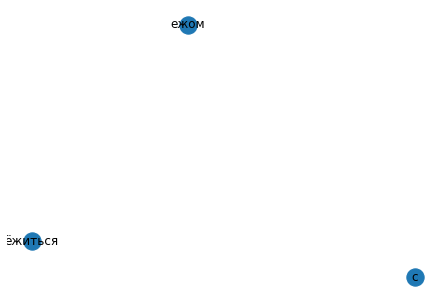

In [77]:
nx.draw(G1, with_labels = True)

In [43]:
nx.draw_networkx_labels?

KeyError: 'ежом'

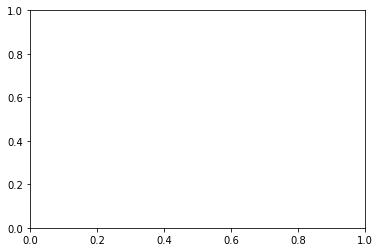

In [51]:
#nx.draw(G1)
nx.draw_networkx_labels(G1, pos=nx.spectral_layout(G))

In [24]:
G.add_node(1)

In [25]:
G.add_node(2)
G.add_node(3)
G.add_node(4)

In [26]:
G.add_edge(1,2) 

In [27]:
G.add_edge(1,3) 

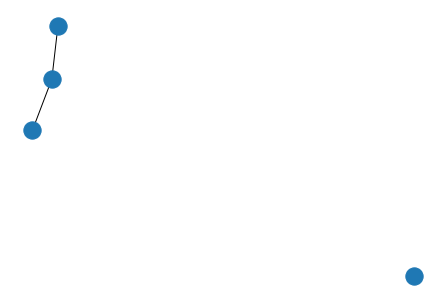

In [28]:
nx.draw(G)

In [7]:
G.__dict__

{'_adj': {1: {2: {}}, 2: {1: {}}},
 '_node': {1: {}, 2: {}},
 'adjlist_inner_dict_factory': dict,
 'adjlist_outer_dict_factory': dict,
 'edge_attr_dict_factory': dict,
 'graph': {},
 'graph_attr_dict_factory': dict,
 'node_attr_dict_factory': dict,
 'node_dict_factory': dict}

TypeError: 'type' object is not iterable

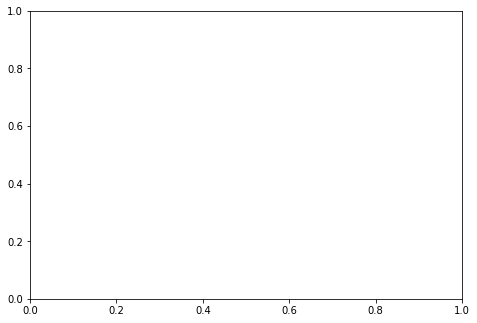

In [11]:
G=nx.Graph
nx.draw(G)   # тип по умолчанию spring_layout
nx.draw(G,pos=nx.spectral_layout(G), nodecolor='r',edge_color='b')


In [49]:
import matplotlib.pyplot as plt

ёжиться
с
ежом


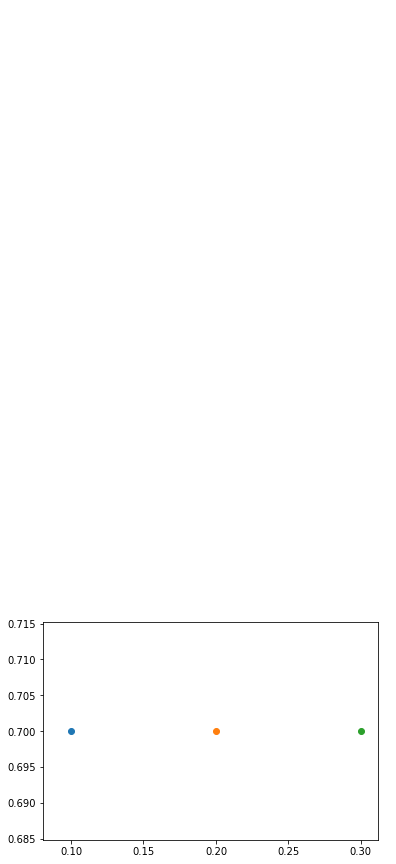

In [70]:
f = plt.subplot()
t = 0.1
for curWordParse in res.parsePointWordList:
    f.scatter(t, 0.7)
    print(curWordParse.word.word)
    f.annotate(curWordParse.word.word,(t, 0.8))
    t += 0.1
plt.show()

In [ ]:
f.

In [60]:
plt.scatter(2.0, 1.0)
plt.annotate("me", (0.5, 0.5))

Text(0.5, 0.5, 'me')

In [ ]:
Все округляем до второго знака.
Вектор запроса — (29972.25, 13983.84, 31170.42, 37852.5), после нормализации - (0.51, 0.24, 0.53, 0.64).
Вектор первого документа — (44.55, 6.24, 0, 21), после нормализации - (0.9, 0.13, 0, 0.42).
Вектор второго документа — (6.6, 67.65, 53.46, 0), после нормализации -  (0.08, 0.78, 0.62, 0).
Вектор третьего документа — (39.6, 0, 46.98, 25.5),  после нормализации - (0.59, 0, 0.70, 0.38).
Посчитаем косинусы.
Для первого документа cos(q, d1) = ((0.51, 0.24, 0.53, 0.64), (0.9, 0.13, 0, 0.42)) / (len(q) * len(d1)) = (0.46 + 0.03 + 0 + 0.27) / 1 = 0.76
Для второго документа cos(q, d2) = ((0.51, 0.24, 0.53, 0.64), (0.08, 0.78, 0.62, 0)) / (len(q) * len(d2)) = (0.04 + 0.19 + 0.33 + 0) / 1 = 0.56
Для третьего документа cos(q, d3) = ((0.51, 0.24, 0.53, 0.64), (0.59, 0, 0.70, 0.38)) / (len(q) * len(d3)) = (0.30 + 0 + 0.37 + 0.24) / 1 = 0.9


In [23]:
(0.51, 0.24, 0.53, 0.64), (0.59, 0, 0.70, 0.38) = (0.30, 0, 0.37, 0.24)

TypeError: can't multiply sequence by non-int of type 'tuple'

In [43]:
0.3 + 0.37 + 0.24

0.9099999999999999

In [35]:
0.24 * 0.78

0.1872

In [26]:
0.64 * 0.42

0.2688

In [ ]:
(1.65, 0, 1.62, 0), после нормализации - (0.71, 0, 0.70, 0)

In [2]:
import math

In [79]:
math.sqrt(1.65 ** 2 + 0 ** 2 + 1.62 ** 2 + 0 ** 2)

2.3123364807051763

In [81]:
1.62 / 2.3123364807051763

0.7005900799982019

In [ ]:
Для первого документа cos(q, d1) = ( (0.71, 0, 0.70, 0), (0.9, 0.13, 0, 0.42)) / (len(q) * len(d1)) = (0.64 + 0 + 0 + 0) / 1 = 0.64
Для второго документа cos(q, d2) = ( (0.71, 0, 0.70, 0), (0.08, 0.79, 0.61, 0)) / (len(q) * len(d2)) = (0.06 + 0 + 0.43 + 0) / 1 = 0.49
Для третьего документа cos(q, d3) = ( (0.71, 0, 0.70, 0), (0.59, 0, 0.70, 0.38)) / (len(q) * len(d3)) = (0.42 + 0 + 0.4 + 0) / 1 = 0.91.
В итоге, самое большое значение косинуса у третьего документа, поэтому третий документ подходит лучше всего.


In [84]:
q = [0.71, 0, 0.70, 0]
d = [0.08, 0.79, 0.61, 0]
res = []
for i in range(4):
    res.append(d[i] * q[i])
    print(res[i], end = '+')
ans = 0
print()
for i in res:
    ans += i
print(ans)

0.056799999999999996+0.0+0.427+0+
0.4838


In [ ]:
0.06 + 0 + 0.43 + 0